In [3]:
import quandl
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd

In [4]:
tf.__version__

'2.0.0-beta1'

### 1. Data Download

In [5]:
def get_quandl_data(quandl_id):
    '''Download and cache Quandl dataseries'''
    cache_path = '{}.pkl'.format(quandl_id).replace('/','-')
    try:
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(quandl_id))
    except (OSError, IOError) as e:
        print('Downloading {} from Quandl'.format(quandl_id))
        df = quandl.get(quandl_id, returns="pandas")
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(quandl_id, cache_path))
    return df

In [6]:
btc = get_quandl_data('BCHARTS/KRAKENUSD')

Loaded BCHARTS/KRAKENUSD from cache


In [7]:
btc = btc[btc['High'] != 0]

In [9]:
btc.tail()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2019-09-24,9696.0,9776.0,8046.0,8536.7,16440.339465,1.451954e+08,8831.654336
2019-09-25,8535.0,8743.6,8000.0,8439.0,10165.917653,8.553558e+07,8413.955460
2019-09-26,8439.0,8465.7,7730.0,8060.3,10825.208963,8.765095e+07,8096.929216
2019-09-27,8063.0,8290.0,7850.0,8196.0,7405.798149,5.959663e+07,8047.293344
2019-09-28,8195.9,8426.0,8024.9,8173.7,3685.913186,3.011599e+07,8170.563481


### 2. Plot series and split into trainng/validation

In [38]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    size = plt.gcf()
    size.set_size_inches(18,7)
    plt.grid(False)
    plt.rc({'font_size' : 18})
    plt.rcParams.update({'font.size' : 18})
    plt.show()


In [53]:
series = btc['High'][1100:]

In [55]:
time = np.arange(1,len(series)+1)

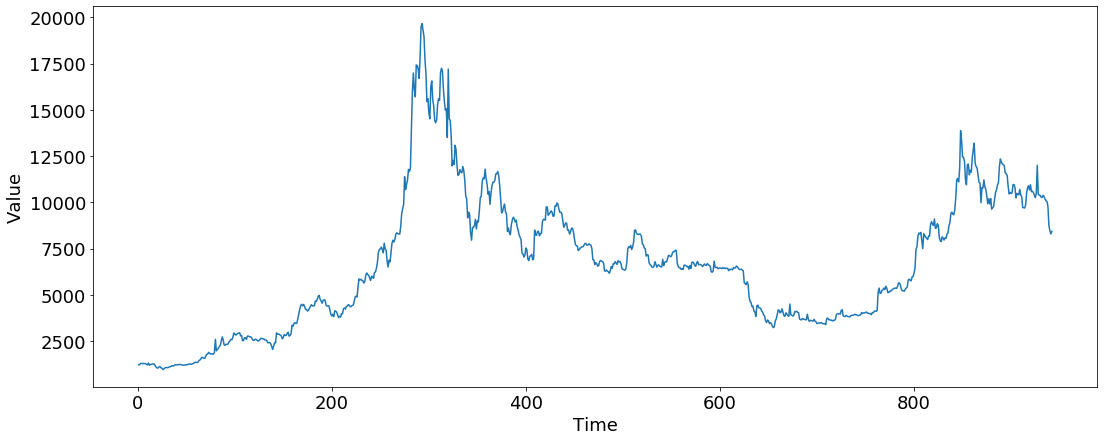

In [56]:
plot_series(time,series)

In [60]:
split_time = 600
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

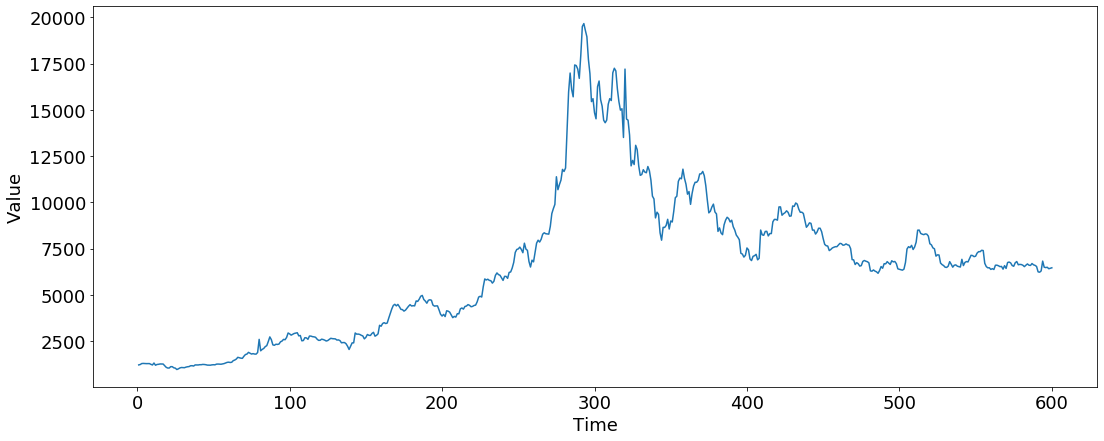

In [61]:
plot_series(time_train, x_train)

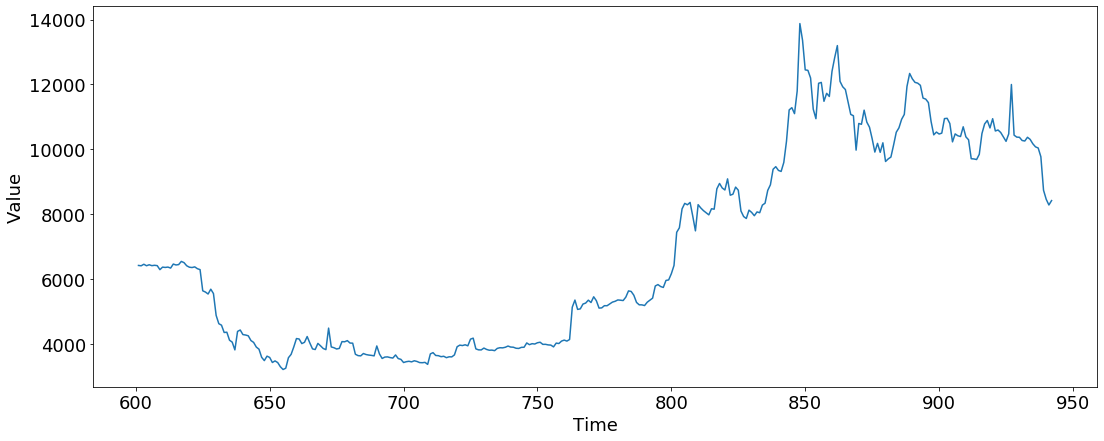

In [62]:
plot_series(time_valid, x_valid)

### 3. Autocorrelation

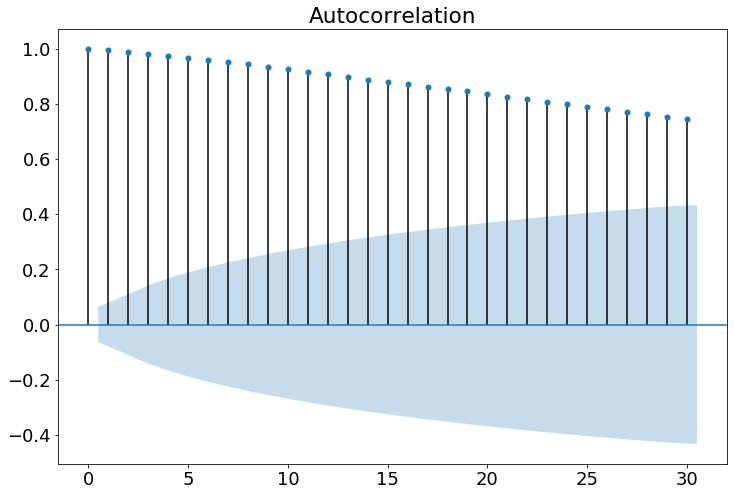

In [63]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(series)

size = plt.gcf()
size.set_size_inches(12,8)
plt.show()

### 4. Partial Autocorrelation

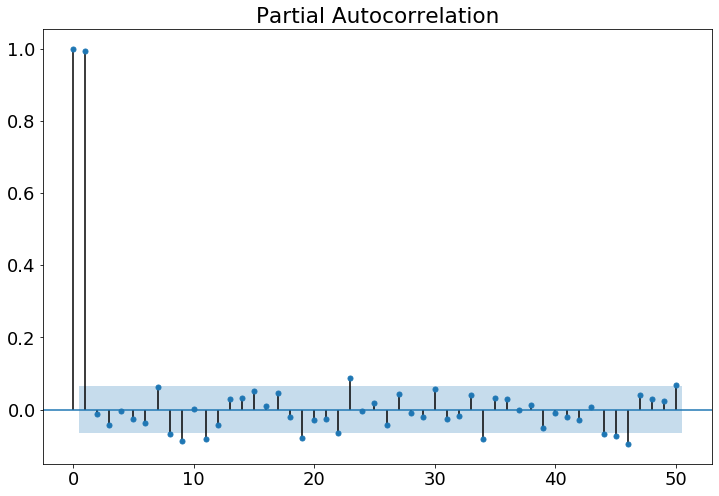

In [64]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(series, lags=50)

size = plt.gcf()
size.set_size_inches(12,8)
plt.show()

### 5. Time Series Decomposition

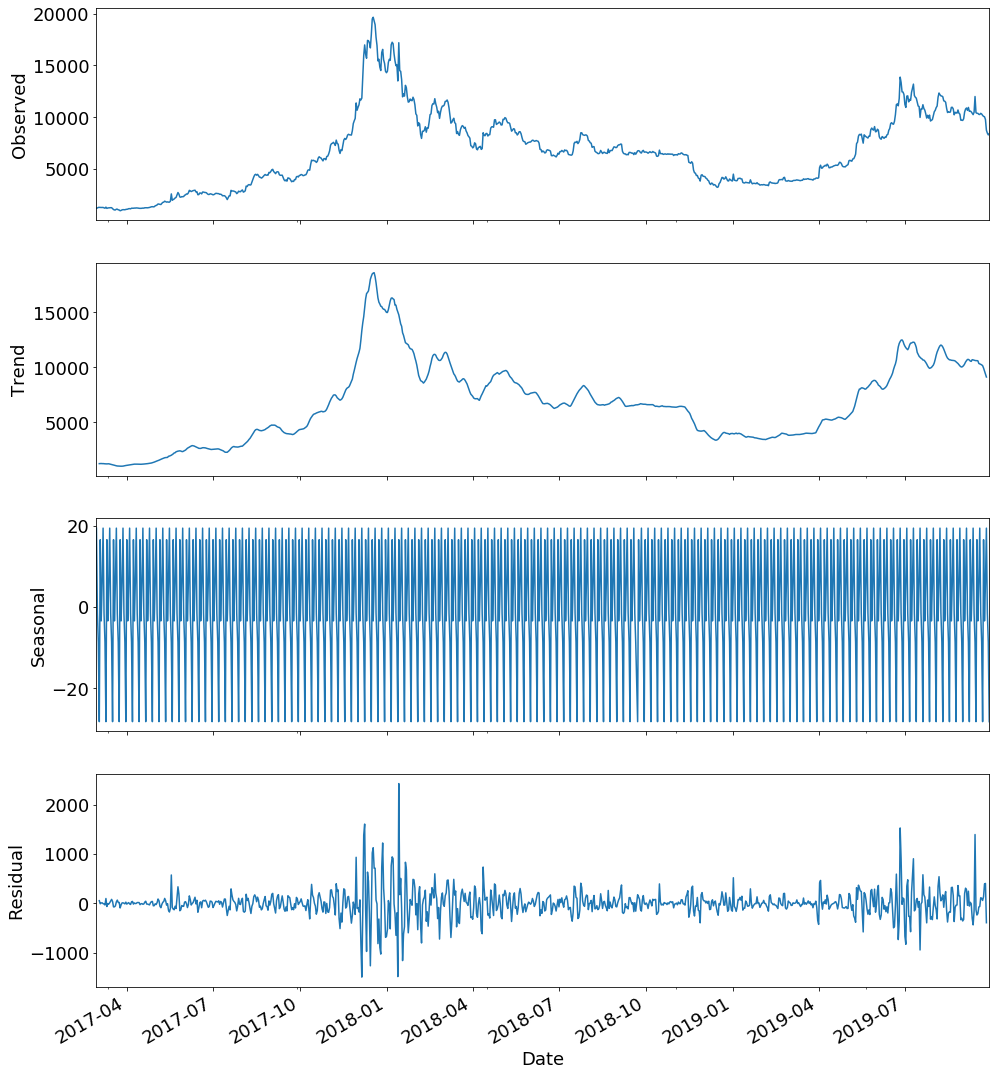

In [70]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(series, model='additive', freq=7)
result.plot()

size = plt.gcf()
size.set_size_inches(16,20)
plt.show()

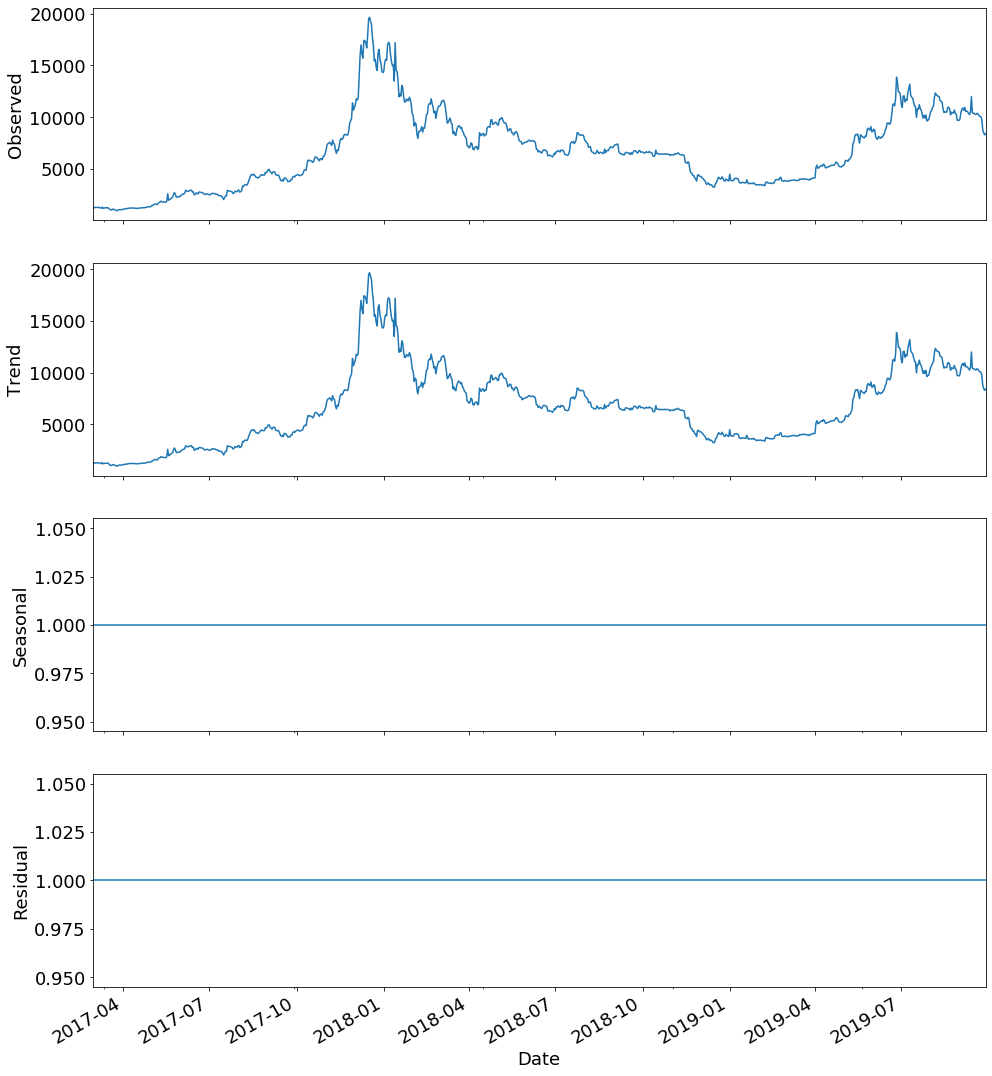

In [67]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(series, model='multiplicative', freq=1)
result.plot()

size = plt.gcf()
size.set_size_inches(16,20)
plt.show()

### 6. Stationarity Test

In [80]:
from statsmodels.tsa.stattools import adfuller
X = series.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.242128
p-value: 0.191312
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568


### 7. Naive Forecast

In [73]:
from sklearn.metrics import mean_squared_error
from math import sqrt

p=1 RMSE:322.363
p=2 RMSE:464.322
p=3 RMSE:560.468
p=4 RMSE:642.937
p=5 RMSE:730.299
p=6 RMSE:800.711
p=7 RMSE:860.791
p=8 RMSE:927.284
p=9 RMSE:977.937
p=10 RMSE:1016.348
p=11 RMSE:1056.826
p=12 RMSE:1103.141
p=13 RMSE:1146.905
p=14 RMSE:1192.735
p=15 RMSE:1239.507
p=16 RMSE:1269.239
p=17 RMSE:1309.481
p=18 RMSE:1352.397
p=19 RMSE:1396.097
p=20 RMSE:1434.625
p=21 RMSE:1465.837
p=22 RMSE:1489.102
p=23 RMSE:1504.844
p=24 RMSE:1524.296


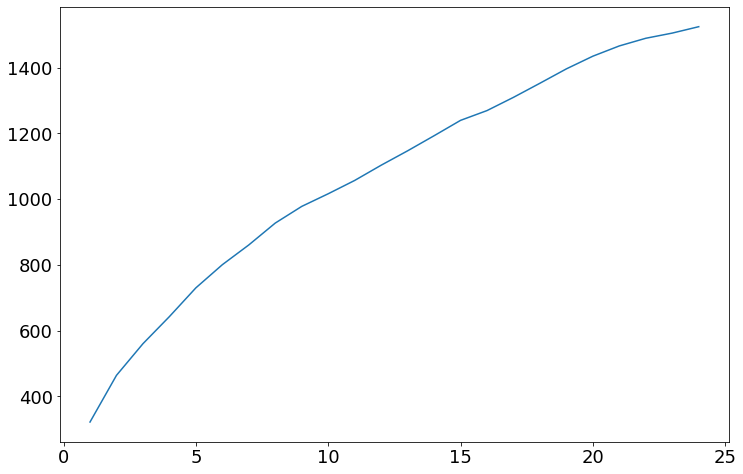

In [88]:
persistence_values = range(1, 25)
scores = list()
for p in persistence_values:
    # walk-forward validation
    history = [x for x in x_train.values]
    predictions = list()
    for i in range(len(x_valid)):
    # make prediction
        yhat = history[-p]
        predictions.append(yhat)
        # observation
        history.append(x_valid[i])
    # report performance
    rmse = sqrt(mean_squared_error(x_valid, predictions))
    scores.append(rmse)
    print('p=%d RMSE:%.3f' % (p, rmse))
# plot scores over persistence values
plt.plot(persistence_values, scores)

size = plt.gcf()
size.set_size_inches(12,8)
plt.show()

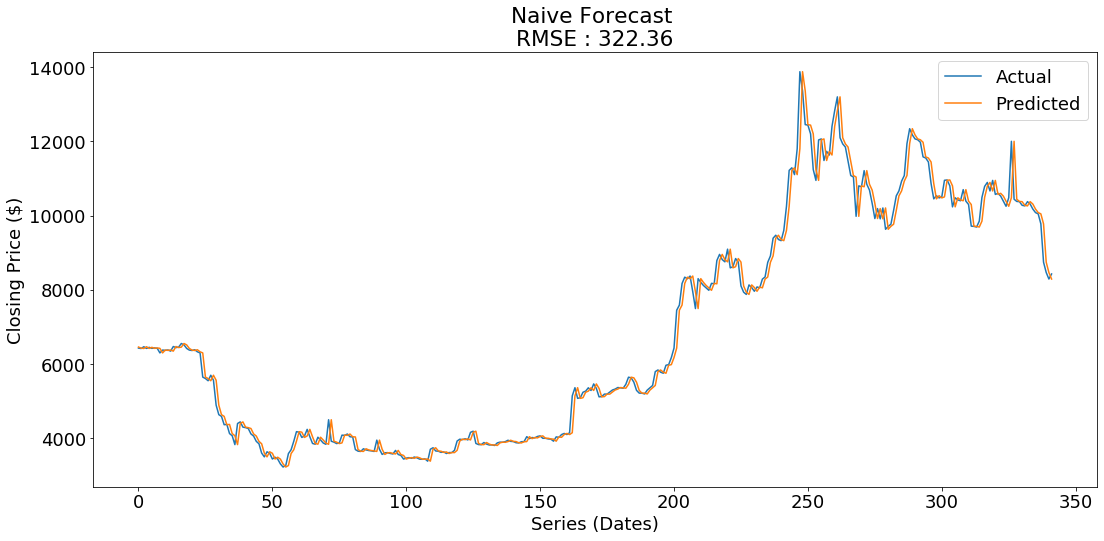

In [109]:
history = [x for x in x_train]
predictions = list()
for i in range(len(x_valid.values)):
    # make prediction
    yhat = history[-1]
    predictions.append(yhat)
    # observation
    history.append(x_valid[i])

rmse = round(sqrt(mean_squared_error(x_valid, predictions)),2)

# plot predictions vs observations
plt.plot(x_valid.values, label = 'Actual')
plt.plot(predictions, label = 'Predicted')
plt.xlabel('Series (Dates)')
plt.ylabel('Closing Price ($)')
plt.legend()
plt.title('Naive Forecast \n' + 'RMSE : ' + str(rmse))
size = plt.gcf()
size.set_size_inches(18,8)
plt.show()

In [ ]:
rmse = 